fpkm shape: (887, 19962)
deconvo shape: (835, 9853)
tpm shape: (887, 19969)
event.PAM50
LumA     464
LumB     193
Basal    146
Her2      74
Name: count, dtype: int64


Fitting size factors...
... done in 0.15 seconds.

Fitting dispersions...
... done in 1.63 seconds.

Fitting dispersion trend curve...
... done in 1.54 seconds.

Fitting MAP dispersions...
... done in 2.25 seconds.

Fitting LFCs...
... done in 3.64 seconds.

Refitting 817 outliers.

Fitting dispersions...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 0.11 seconds.

Fitting LFCs...
... done in 0.25 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: HRD-status-base HRD vs HR


... done in 2.78 seconds.



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG_0,0.000000,NaN,NaN,NaN,NaN,NaN
A1CF_1,0.000000,NaN,NaN,NaN,NaN,NaN
A2M_2,108.929448,0.536441,0.082727,6.484505,8.902384e-11,4.955107e-10
A2ML1_3,2.008594,2.505055,0.496418,5.046257,4.505491e-07,1.596020e-06
A3GALT2_4,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
ZYG11A_20005,0.878507,0.798181,0.135854,5.875266,4.221655e-09,1.915863e-08
ZYG11B_20006,5.352988,0.102598,0.049239,2.083669,3.719033e-02,6.202685e-02
ZYX_20007,50.794143,0.102078,0.053395,1.911762,5.590671e-02,8.963461e-02
ZZEF1_20008,3.645708,-0.216601,0.063411,-3.415803,6.359434e-04,1.453404e-03


Mean Squared Error: 0.032
R^2 Score: 0.650


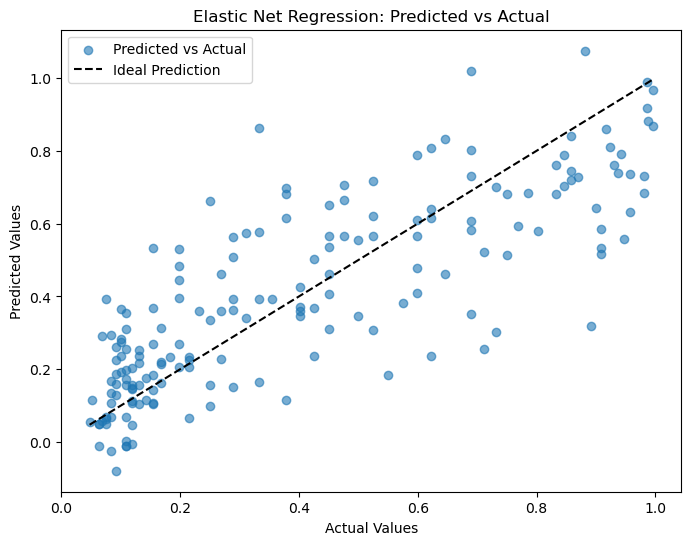

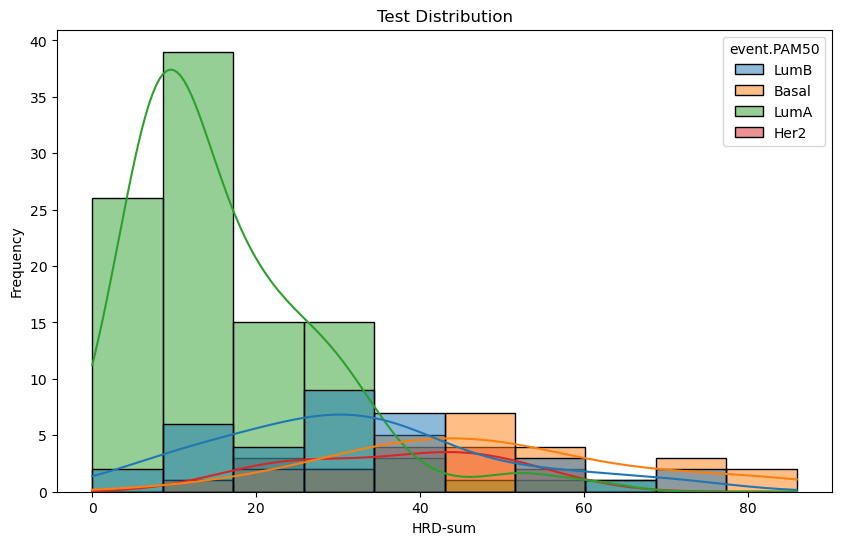

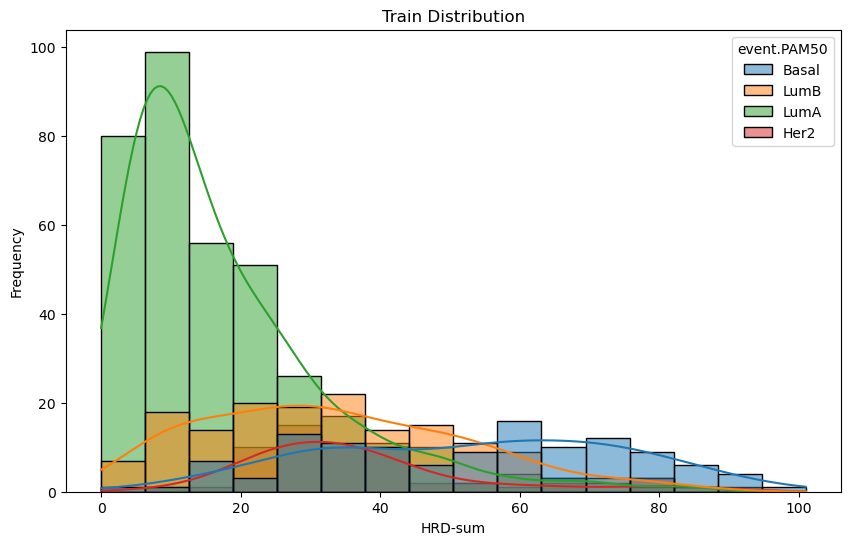

In [85]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# -------------------- Data Loading and Preprocessing --------------------

# Load metadata and HRD scores
ann_tcga = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
hrd_scores = pd.read_excel('../data/tcga.hrdscore.xlsx', index_col=0)

# Load RNAseq data
fpkm = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
deconvo = pd.read_csv('../data/Deconvo2.csv',  index_col=0)
tpm = pd.read_csv('../data/tpm.csv', index_col=0, low_memory=False)

# Filter metadata
metadata = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
metadata = metadata[~metadata['event.PALB2'].ne('0')]
metadata = metadata[metadata['event.BRCA1'] != '1']
metadata.index = metadata.index.str.replace('.', '-', regex=False)
hrd_scores.index = hrd_scores.index.map(lambda x: x[:12])
metadata = metadata.merge(hrd_scores[['HRD-sum']], left_index=True, right_index=True, how='inner')

# Process fpkm data
fpkm = fpkm.set_index('Case ID')
fpkm = fpkm[fpkm['Sample Type'] == 'Primary Tumor']
fpkm = fpkm.drop(columns=["Sample ID","Sample Type"])

# Rename columns using a dictionary constructed from fpkm columns
dick = {}
for i, v in enumerate(fpkm.columns):
    parts = v.split('|')
    if len(parts) > 1:
        dick[parts[0]] = parts[1]
tpm = tpm.rename(columns=dick)
tpm = tpm[~tpm.index.duplicated(keep='first')]

# Keep only Primary Tumor samples in tpm
tpm = tpm.loc[tpm.index.str[13:15] == "01"]

filtered_columns = [col for col in fpkm.columns if '|' in col and 'protein_coding' in col.split('|')[2]]
fpkm = fpkm[filtered_columns]

# Further processing for fpkm
fpkm.columns = [col.split('|')[1] if '|' in col else col for col in fpkm.columns]
fpkm.index = fpkm.index.map(lambda x: x[:12])
fpkm = fpkm.loc[fpkm.index.intersection(metadata.index)]
fpkm.sort_index(inplace=True)
fpkm = fpkm.rename_axis("fpkm", axis="index")
fpkm = fpkm.apply(pd.to_numeric, errors='coerce')
fpkm.fillna(0, inplace=True)

# Process deconvo
deconvo.index = deconvo.index.map(lambda x: x[:12])
deconvo = deconvo.loc[deconvo.index.intersection(metadata.index)]
deconvo.sort_index(inplace=True)
deconvo = deconvo.rename_axis("deconvo", axis="index")
deconvo.fillna(0, inplace=True)

# Process tpm
tpm.index = tpm.index.map(lambda x: x[:12])
tpm = tpm.loc[tpm.index.intersection(metadata.index)]
tpm.sort_index(inplace=True)
tpm = tpm.rename_axis("tpm", axis="index")
tpm = tpm.apply(pd.to_numeric, errors='coerce')
tpm.fillna(0, inplace=True)
tpm = tpm[tpm.columns.intersection(fpkm.columns)]


print(f"fpkm shape: {fpkm.shape}")
print(f"deconvo shape: {deconvo.shape}")
print(f"tpm shape: {tpm.shape}")

# Display counts for PAM50 subtypes
pam50_counts = metadata['event.PAM50'].value_counts()
print(pam50_counts)

# -------------------- Helper Functions --------------------

def downsampling_lumA(metadata, lumA_cutoff):
    """Downsamples LumA samples to match HRD count."""
    lumA_HRD = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] >= lumA_cutoff)]
    lumA_HRP = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] < lumA_cutoff)]
    if lumA_HRP.shape[0] < lumA_HRD.shape[0]:
        return metadata, pd.DataFrame()
    lumA_HRP_downsampled = lumA_HRP.sample(n=lumA_HRD.shape[0], random_state=42)
    df_downsampled = pd.concat([lumA_HRD, lumA_HRP_downsampled])
    df_downsampled = pd.concat([df_downsampled, metadata[metadata['event.PAM50'] != 'LumA']])
    unused_majority = lumA_HRP.loc[~lumA_HRP.index.isin(lumA_HRP_downsampled.index)]
    return df_downsampled, unused_majority

def add_back_test(rna_df, removed_samples, X_test, y_test):
    """Adds back removed samples to the test set if required."""
    add_back_features = rna_df.loc[rna_df.index.intersection(removed_samples.index)]
    add_back_features = add_back_features.sort_index()
    add_back_y = removed_samples.loc[removed_samples.index.intersection(rna_df.index)]
    add_back_y = add_back_y.sort_index()
    X_test = pd.concat([X_test, add_back_features])
    y_test = pd.concat([y_test, add_back_y['HRD-sum'].squeeze()])
    return X_test, y_test

def sigmoid_transform(values, shift=0, scale=1):
    """Apply sigmoid transformation to a series of values."""
    return 1 / (1 + np.exp(-scale * (values - shift)))

def binary_hrd(values, threshold):
    """Convert continuous HRD values into binary classes based on a threshold."""
    return (values >= threshold).astype(int)

def plot_test_train_pam50_dist(metadata, X_train, X_test):
    """Plot HRD-sum distributions for training and test samples, colored by PAM50 subtype."""
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_test.index)],
                 x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Test Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_train.index)],
                 x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Train Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

def runDESeq2(counts, metadata, design_factors):
    """Run differential expression analysis using DESeq2 (via pydeseq2)."""
    counts = counts.copy()
    # Make gene names unique
    counts.columns = pd.Index(counts.columns).str.split('_').str[0] + '_' + pd.Series(range(len(counts.columns))).astype(str)
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors=design_factors,
        # n_jobs=-1
    )
    dds.deseq2()
    stats = DeseqStats(dds)
    stats.summary()
    results = stats.results_df
    return results

def check_deseq2_data(counts_df, metadata_df, design_factor):
    common_indices = counts_df.index.intersection(metadata_df.index)    
    return common_indices

def prepare_deseq2_data(counts_df, metadata_df, common_indices):
    counts_aligned = counts_df.loc[common_indices]
    metadata_aligned = metadata_df.loc[common_indices]
    assert counts_aligned.index.equals(metadata_aligned.index), "Indices not aligned"
    assert counts_aligned.index.is_unique, "Duplicate indices present"
    return counts_aligned, metadata_aligned

# -------------------- Prepare Data for DESeq2 --------------------

# Use tpm as your gene expression data
features_df = fpkm
metadata_truncated = metadata.loc[metadata.index.intersection(features_df.index)]
# Add a base HRD status (not used in the final regression but for DESeq2 design)
metadata_truncated['HRD_status_base'] = metadata_truncated['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')
softLabel_metadata = metadata_truncated.sort_index()

features_df = features_df.fillna(0).astype(int)
features_df = features_df[sorted(features_df.columns)]
gene_expression_int = features_df.sort_index()
common_idx = check_deseq2_data(gene_expression_int, softLabel_metadata, 'HRD_status_base')
gene_expression_aligned, softLabel_metadata_aligned = prepare_deseq2_data(
    gene_expression_int, 
    softLabel_metadata,
    common_idx
)
basic = runDESeq2(gene_expression_aligned, softLabel_metadata_aligned, 'HRD_status_base')

# -------------------- Model Training Function --------------------
common_de_genes = []
def train_model(params, metadata):
    global common_de_genes
    # Filter differential expression results based on the provided p-value and fold-change thresholds
    basic_filt = basic[(basic["padj"] <= params['pvals'])]
    # Extract gene names (removing the added unique suffix)
    de_genes = [gene.split('_')[0] for gene in basic_filt.index]

    # Subset the expression data to only include DE genes
    features_df = gene_expression_int.loc[:, gene_expression_int.columns.isin(de_genes)]
    labels_df = metadata_truncated['HRD-sum'].sort_index()
    features_df = features_df.sort_index()
    
    # Normalize features if requested
    if params['normalization'] == 'StandardScaler':
        scaler = StandardScaler()
        features_df = pd.DataFrame(scaler.fit_transform(features_df), index=features_df.index, columns=features_df.columns)
    elif params['normalization'] == 'log2':
        features_df = np.log2(features_df + 1)
    
    # Apply soft labeling
    if params['softlabels'] == "Sigmoid":
        labels_df = sigmoid_transform(labels_df, params['softlabel_thresholds'], params['softlabel_gradients'])
    elif params['softlabels'] == "Binary":
        labels_df = binary_hrd(labels_df, params['softlabel_thresholds'])
    
    # Optionally downsample LumA samples (here, we are not downsampling because fixed params indicate False)
    removed_samples = None
    if params['downsample'][0]:
        df_downsampled, removed_samples = downsampling_lumA(metadata_truncated, params['downsample_thresholds'])
        features_df = features_df.loc[features_df.index.intersection(df_downsampled.index)]
        labels_df = df_downsampled.loc[df_downsampled.index.intersection(features_df.index), 'HRD-sum']
    
    labels = labels_df.squeeze()
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)
    
    # Optionally add back removed samples to test set if required
    if params['downsample'][1] and removed_samples is not None:
        X_test, y_test = add_back_test(features_df, removed_samples, X_test, y_test)
    
    # Train the ElasticNet model
    warnings.filterwarnings("ignore")
    model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and evaluate on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    common_de_genes = features_df.columns
    
    return mse, r2, model, X_train, X_test, y_test, y_pred

# -------------------- Run with Fixed Parameters --------------------

# Use the fixed parameters as specified
fixed_params = {
    'softlabels': 'Sigmoid', 
    'softlabel_thresholds': 30, 
    'softlabel_gradients': 0.1, 
    'pvals': 0.01, 
    'normalization': 'log2', 
    'l1_ratio': 0.5, 
    'downsample_thresholds': 35, 
    'downsample': (False, False), 
    'alpha': 0.01
}

# Train the model with the fixed parameters
mse, r2, model, X_train, X_test, y_test, y_pred = train_model(fixed_params, metadata)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Save the trained model if desired
joblib.dump(model, 'best_model.joblib')

# -------------------- Plotting --------------------

# Plot Predicted vs. Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Elastic Net Regression: Predicted vs Actual')
plt.legend(loc="upper left")
plt.show()

# Optionally, plot the training and test distribution of HRD-sum (colored by PAM50 subtype)
plot_test_train_pam50_dist(metadata_truncated, X_train, X_test)


In [86]:
#len(common_de_genes)

In [87]:
#[print(n) for n in common_de_genes if n[0]=='R']

In [88]:
[print(n) for i in ['brca1', 'brca2', 'palb2', 'rad51', 'parp1', 'parp2', 'parp3'] for n in common_de_genes if n == i.upper()]


BRCA2
RAD51
PARP1
PARP2
PARP3


[None, None, None, None, None]

In [89]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr
from sklearn.preprocessing import StandardScaler

# -------------------------
# 1. Load and Preprocess Expression Data
# -------------------------
ispy2_expr = pd.read_csv(
    '../data/validation/GSE173839_ISPY2_AgilentGeneExp_durvaPlusCtr_FFPE_meanCol_geneLevel_n105.txt',
    sep='\t'
)
ispy2_expr.set_index('GeneName', inplace=True)
ispy2_expr_transposed = ispy2_expr.T
ispy2_expr_transposed.sort_index(inplace=True)




In [90]:
df_filtered = ispy2_expr_transposed.loc[:, ispy2_expr_transposed.columns.intersection(common_de_genes)]

# Identify missing genes that need to be added
missing_genes = set(common_de_genes) - set(df_filtered.columns)

# Add missing columns with 0s
for gene in missing_genes:
    df_filtered[gene] = 0

# Reorder columns to match top_genes_de
df_filtered = df_filtered[common_de_genes]
validation_subset =df_filtered
validation_subset.fillna(0, inplace=True)
validation_subset

,A2M,A2ML1,AAAS,AADAT,AAGAB,AAMDC,AARD,AARS1,AARS2,AASS,...,ZSWIM6,ZSWIM7,ZSWIM8,ZUP1,ZW10,ZWILCH,ZWINT,ZXDB,ZYG11A,ZZEF1
102596,8.231,5.691,9.096,6.071,8.448,8.926,6.171,0,7.988,6.231,...,9.856,7.258,8.148,0,7.068,6.504,8.790,9.193,6.736,6.729
111922,9.978,6.501,8.877,7.883,9.173,8.692,6.329,0,8.315,7.014,...,9.657,7.744,9.097,0,6.992,6.825,7.839,9.536,5.600,5.960
115724,10.390,5.542,8.672,5.637,8.880,9.297,7.419,0,8.323,8.169,...,10.030,6.964,8.764,0,5.182,6.414,9.675,8.745,5.028,6.755
123591,8.214,7.183,8.750,5.550,8.967,8.027,8.955,0,8.163,5.863,...,9.503,7.563,7.858,0,6.702,6.451,8.668,9.371,6.971,6.993
134956,9.422,5.233,9.951,4.866,9.820,8.964,6.489,0,8.059,8.284,...,10.110,7.344,8.386,0,6.594,6.926,8.845,8.784,6.153,7.423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944184,9.795,5.490,9.553,5.715,9.984,10.150,7.379,0,8.342,7.154,...,9.336,7.395,7.996,0,5.947,6.610,9.070,9.461,5.320,7.225
965961,9.082,6.861,8.908,5.993,9.535,9.316,9.434,0,7.781,6.939,...,9.441,7.787,8.580,0,6.190,6.837,8.579,8.710,5.536,6.860
979809,10.630,7.202,9.145,5.997,9.084,9.673,7.870,0,8.191,7.331,...,9.584,7.304,8.539,0,6.703,6.499,8.989,8.701,6.987,6.964
989123,11.230,6.418,9.251,6.445,8.687,8.880,10.860,0,7.636,7.193,...,9.628,7.799,8.052,0,7.297,7.063,8.721,8.900,5.998,6.777


In [91]:


# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(validation_subset)

# Step 5: Make predictions using the trained model
predictions = model.predict(scaled_data)
print(predictions)

# -------------------------
# 3. Load and Preprocess Response Data
# -------------------------
ispy2_response = pd.read_csv(
    '../data/validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv'
)
# Adjust pCR.status (-1 indicates control arm)
ispy2_response.loc[ispy2_response["pCR.status"] == -1, "pCR.status"] = 0

ispy2_response.sort_values(by='ResearchID', inplace=True)
ispy2_response["ResearchID"] = ispy2_response["ResearchID"].astype(str).str.strip()

# Subset expression data to match the ResearchID order in the response data
ispy2_expr = ispy2_expr[ispy2_response["ResearchID"]]
ispy2_response.set_index('ResearchID', inplace=True)

# -------------------------
# 4. Merge Expression and Response Data
# -------------------------
# Find common indices between the expression and response datasets
common_indices = ispy2_expr_transposed.index.intersection(ispy2_response.index)

# Filter both DataFrames to include only the common indices (maintaining order)
filtered_ispy_probe = ispy2_expr_transposed.loc[common_indices]
filtered_ispy_response = ispy2_response.loc[common_indices]

# Append model predictions to the response DataFrame
filtered_ispy_response['predictions'] = predictions

# -------------------------
# 5. Visualization: Box Plot of Predictions by pCR.status
# -------------------------
px.box(
    filtered_ispy_response,
    y='predictions',
    x='pCR.status',
    points="all",
    title="Distribution of regression scores between patients' complete pathological response"
)

# -------------------------
# 6. Statistical Testing: Welch's t-test & Mann-Whitney U Test
# -------------------------
group_0 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 0, 'predictions']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 1, 'predictions']

t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

# -------------------------
# 7. Visualization: Scatter Plot with Pearson Correlation
# -------------------------
# Data for plotting
x = filtered_ispy_response['PARPi7_sig.']
y = filtered_ispy_response['predictions']

# Calculate Pearson correlation coefficient and p-value
r_value, p_value = pearsonr(x, y)

# Create scatter plot with regression trendline
fig = px.scatter(
    filtered_ispy_response,
    x='PARPi7_sig.',
    y='predictions',
    title="Regression scores between patients against PARPi7 sig scores",
    labels={'PARPi7_sig.': 'PARPi7 Signal', 'predictions': 'Predictions'},
    color='pCR.status',
    trendline="ols",  # Add regression line
    color_continuous_scale='magenta'  # Use a more subtle color palette
)

# Add annotation for Pearson R and p-value
fig.add_annotation(
    x=np.mean(x),
    y=np.max(y),
    text=f"Pearson R: {r_value:.2f}<br>p-value: {p_value:.2e}",
    showarrow=False,
    font=dict(size=14, color="black"),
    align="center",
    bordercolor="black",
    borderwidth=1,
    borderpad=4,
    bgcolor="white",
    opacity=1.0
)

# Display the scatter plot
fig.show()


[-7.06563092e-02 -7.35399995e-02  1.91366652e-01  8.78968267e-02
  1.84323011e-02 -9.05062110e-02 -2.36265323e-01 -8.73564680e-02
 -1.39507330e-01  4.38301810e-02 -2.17798669e-01 -9.30666712e-02
  1.79252240e-01 -2.89525095e-01 -6.01593327e-02 -9.20930191e-03
  2.54164278e-01 -1.61074728e-02 -1.91049782e-01 -1.70624733e-01
 -4.48662694e-02 -4.38348202e-03 -5.69689844e-02 -7.92460262e-02
 -1.75444404e-01 -1.45882694e-02 -1.29379562e-01  4.87825922e-02
  1.43676019e-01  1.58161825e-02  2.53432409e-01  3.01130075e-02
  7.08990796e-02  6.25704432e-02  2.01292931e-01  1.59037816e-01
 -1.84878251e-01  5.48727148e-02  8.73517660e-02  5.93861784e-03
 -2.08062130e-01  2.01299105e-01 -2.11119305e-02 -6.49254987e-02
 -3.74617799e-02 -2.57222191e-01 -1.52253974e-02 -3.23740674e-01
  3.32164710e-01  3.24201105e-01  3.39412582e-02  8.47779800e-02
  1.75049782e-01  1.48293017e-01  2.38415103e-01  7.95606331e-02
 -1.09265604e-01 -1.90108798e-02 -1.35815808e-01 -8.47276715e-02
 -5.59600772e-02  1.65639